In [1]:
from localgraphclustering import *

import time
import numpy as np

# Import the graph_tool module for visualization.
from graph_tool.all import * 

# Import matplotlib 
import matplotlib.pyplot as plt

# Just a useful function.
def diff(a, b):
        b = set(b)
        return np.asarray([aa for aa in a if aa not in b], dtype = 'int64')

## Load usroads dataset, load coordinates and initialize reference nodes for Minneapolis + suburban areas

In [2]:
# Read John Hopkins graph.
g = graph_class_local.GraphLocal('./datasets/usroads-cc.graphml','graphml')

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/usroads-cc.xy', dtype = 'Float64')
ld_coord[:,0] = -ld_coord[:,0]

temp1 = np.multiply(ld_coord[:,0] < 95,ld_coord[:,0] > 92.0)
temp2 = np.multiply(ld_coord[:,1] > 44.0,ld_coord[:,1] < 45.9)
temp = np.multiply(temp1,temp2)

#ref_nodes = np.argwhere(ld_coord[:,0] < 79.)
ref_nodes = np.argwhere(temp)
ref_nodes = ref_nodes[:,0]

/usr/local/lib/python3.6/site-packages/localgraphclustering/graph_class_local.py:350: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


## Visualize usroads and Minneapolis

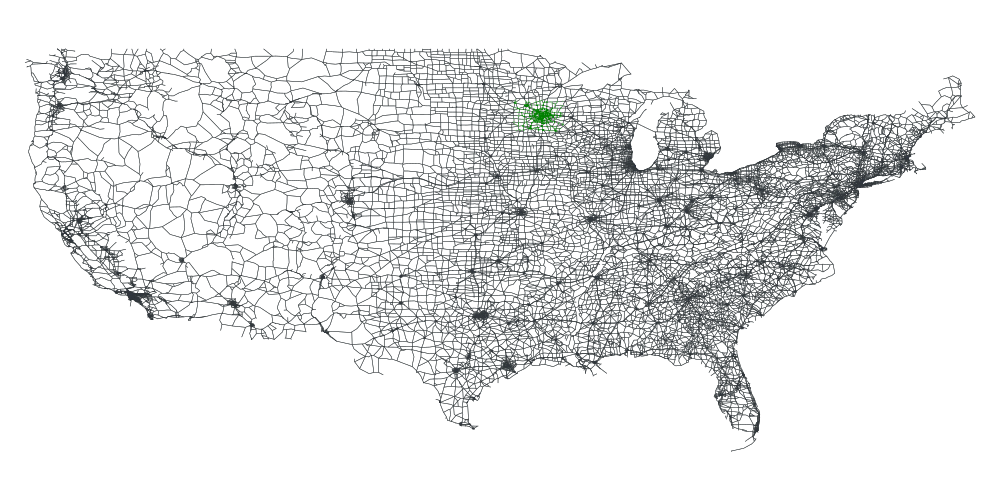

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x128549dd8, at 0x1285499e8>

In [3]:
## Add data to graphtool.
#g_gtool = Graph(directed=False)
#m = g._num_edges
#for i in range(m):
#    g_gtool.add_edge(g.edges[0][i], g.edges[1][i], add_missing=True)  
    
#remove_self_loops(g_gtool)

# Add data to graphtool.
g_gtool = load_graph("./datasets/usroads-cc.graphml")
    
remove_self_loops(g_gtool)

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = -ld_coord[i,:]

temp = np.zeros(g._num_vertices) + 0.0001
temp[ref_nodes] = 1

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in ref_nodes:
    temp[i] = "green"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.5)

# Zoom in Minneapolis + suburban areas

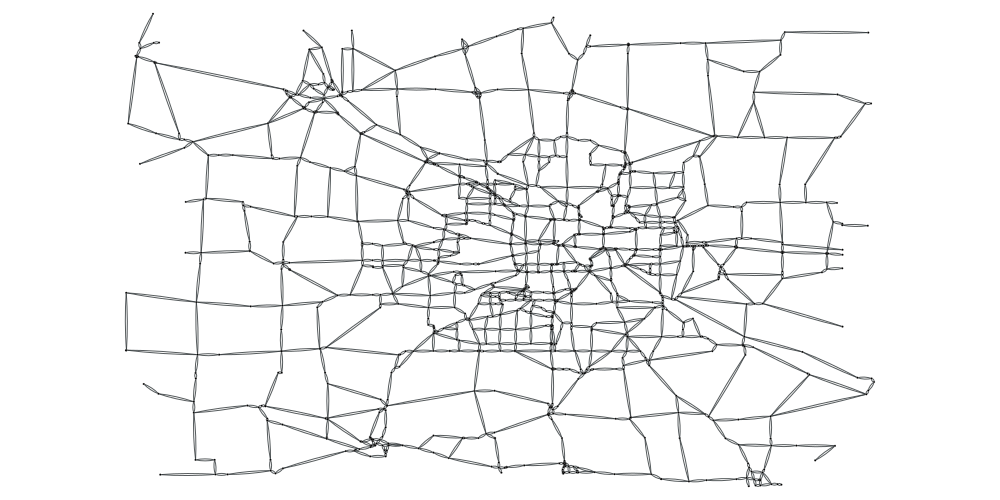

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1285490b8, at 0x1285495f8>

In [4]:
# Copy graph.
keep = np.zeros(g._num_vertices, dtype=bool)
keep[ref_nodes] = True
keep = g_gtool.new_vertex_property("bool",keep)

g2 = Graph(g_gtool)
g2.set_vertex_filter(keep)

g3 = Graph(g2,prune=True)

prop = g3.new_vertex_property("vector<double>")
for i in range(len(ref_nodes)):
    prop[i] = pos[g2.vertex(ref_nodes[i])]
    
temp = np.ones(len(ref_nodes)) + 1

node_size = g3.new_vertex_property("double",temp)

temp = ["black" for x in range(len(ref_nodes))]

node_colours = g3.new_vertex_property("string",temp)

graph_draw(g3, prop, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1)

# Attempt to improve Minneapolis + suburban areas in terms of conductance of the whole graph using MQI. Note that MQI works only within the reference set of nodes.

In [5]:
# Create an object for subgraph node partitioning.
mqi_fast = MQI_fast.MQI_fast()

# Conductance before improvement
print("Conductance before improvement:",g.compute_conductance(ref_nodes))

# Start calling MQI
start = time.time()
output_MQI_fast = mqi_fast.produce([g],[ref_nodes])
end = time.time()
print("running time:",str(end-start)+"s")

# Conductance after improvement
print("Conductance after improvement:",g.compute_conductance(output_MQI_fast[0][0]))

output_MQI = output_MQI_fast[0][0]

Conductance before improvement: 0.0152735351291
running time: 0.2605319023132324s
Conductance after improvement: 0.00996677740864


# Visualize the result of MQI

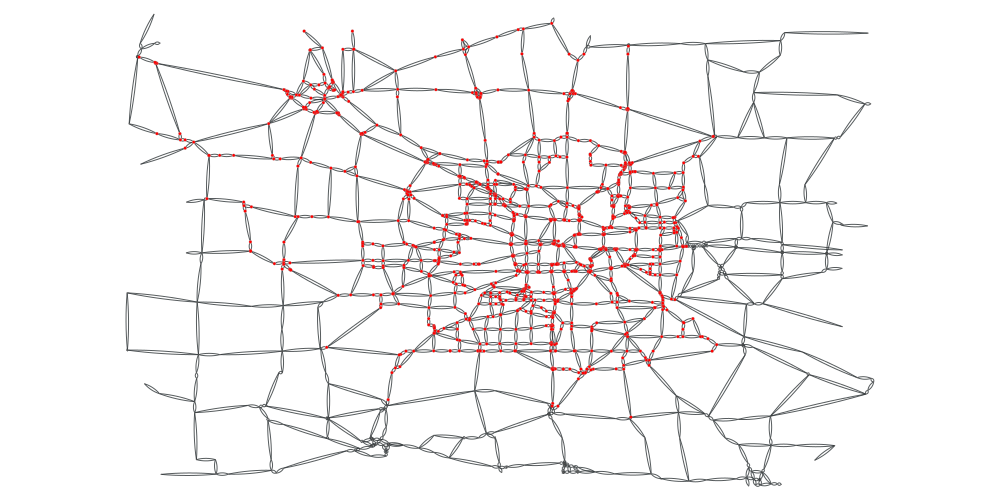

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1285490b8, at 0x1285495f8>

In [6]:
# Plot solutions for Flow Improve
temp = np.zeros(len(ref_nodes))
temp = temp + 0.00001

only_seed = diff(ref_nodes, output_MQI)
# Find node indices in the sub-graph of original cluster after deletion of the complement.
ix = np.in1d(ref_nodes.ravel(), only_seed).reshape(ref_nodes.shape)
idx_only_seed = np.where(ix)[0]


only_mqi = diff(output_MQI, ref_nodes)
# Find node indices in the sub-graph of original cluster after deletion of the complement.
ix = np.in1d(ref_nodes.ravel(), only_mqi).reshape(ref_nodes.shape)
idx_only_mqi = np.where(ix)[0]

intsect = set(ref_nodes).intersection(set(output_MQI))
intsect = list(intsect)
# Find node indices in the sub-graph of original cluster after deletion of the complement.
ix = np.in1d(ref_nodes.ravel(), intsect).reshape(ref_nodes.shape)
idx_intsect = np.where(ix)[0]

temp[idx_only_seed] = 1
temp[idx_only_mqi] = 3
temp[idx_intsect] = 3

node_size = g3.new_vertex_property("double",temp)

temp = ["black" for x in range(len(ref_nodes))]

for i in idx_only_mqi:
    temp[i] = "red"
for i in idx_intsect:
    temp[i] = "red"

node_colours = g3.new_vertex_property("string",temp)

c_map = plt.get_cmap('autumn')

graph_draw(g3, prop, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1)

# Attempt to improve Minneapolis + suburban areas in terms of conductance of the whole graph using Simple Local. Note that Simple Local searches outside the reference set of nodes as well. Therefore, the output might note be a subset of the reference set of nodes.

In [7]:
# Create an object for subgraph node partitioning.
SL_fast = SimpleLocal_fast.SimpleLocal_fast()

# Conductance before improvement
print("Conductance before improvement:",g.compute_conductance(ref_nodes))

# Start calling SimpleLocal
start = time.time()
output_SL_fast = SL_fast.produce([g],[ref_nodes])
end = time.time()
print("running time:",str(end-start)+"s")

# Conductance after improvement
print("Conductance after improvement:",g.compute_conductance(output_SL_fast[0][0]))

output_SL = output_SL_fast[0][0]

Conductance before improvement: 0.0152735351291
running time: 7.079777956008911s
Conductance after improvement: 0.00979020979021


# Visualize the result of Simple Local

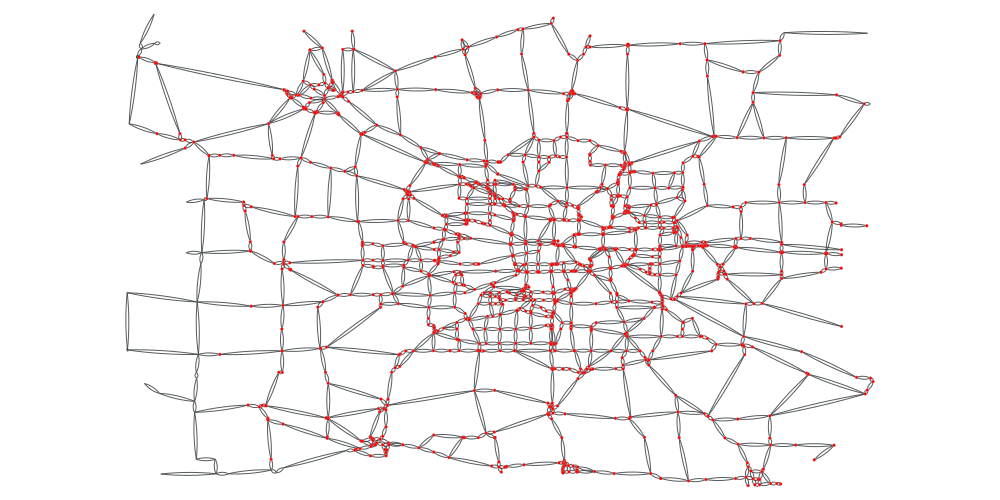

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1285490b8, at 0x1285495f8>

In [8]:
# Plot solutions for Flow Improve
temp = np.zeros(len(ref_nodes))
temp = temp + 0.00001

only_seed = diff(ref_nodes, output_SL)
# Find node indices in the sub-graph of original cluster after deletion of the complement.
ix = np.in1d(ref_nodes.ravel(), only_seed).reshape(ref_nodes.shape)
idx_only_seed = np.where(ix)[0]


only_SL = diff(output_SL, ref_nodes)
# Find node indices in the sub-graph of original cluster after deletion of the complement.
ix = np.in1d(ref_nodes.ravel(), only_SL).reshape(ref_nodes.shape)
idx_only_SL = np.where(ix)[0]

intsect = set(ref_nodes).intersection(set(output_SL))
intsect = list(intsect)
# Find node indices in the sub-graph of original cluster after deletion of the complement.
ix = np.in1d(ref_nodes.ravel(), intsect).reshape(ref_nodes.shape)
idx_intsect = np.where(ix)[0]

temp[idx_only_seed] = 1
temp[idx_only_SL] = 3
temp[idx_intsect] = 3

node_size = g3.new_vertex_property("double",temp)

temp = ["black" for x in range(len(ref_nodes))]

for i in idx_only_SL:
    temp[i] = "red"
for i in idx_intsect:
    temp[i] = "red"

node_colours = g3.new_vertex_property("string",temp)

c_map = plt.get_cmap('autumn')

graph_draw(g3, prop, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1)

# Visualize the result of Simple Local using the whole graph

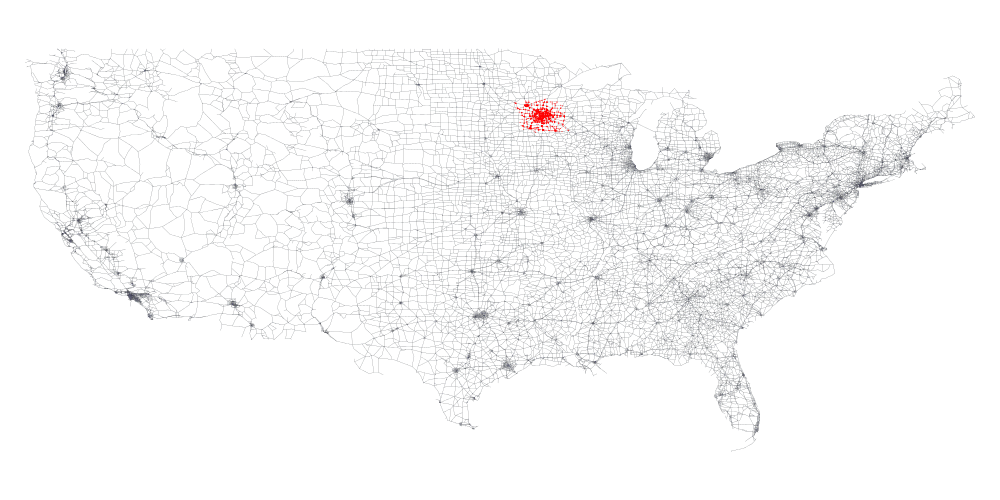

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x128549dd8, at 0x1285499e8>

In [9]:
temp = np.zeros(g._num_vertices) + 0.00001
temp[output_SL] = 1

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_SL:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1)

# Get an initial partition of Senate using spectral partitioning 

/usr/local/lib/python3.6/site-packages/localgraphclustering/graph_class_local.py:350: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


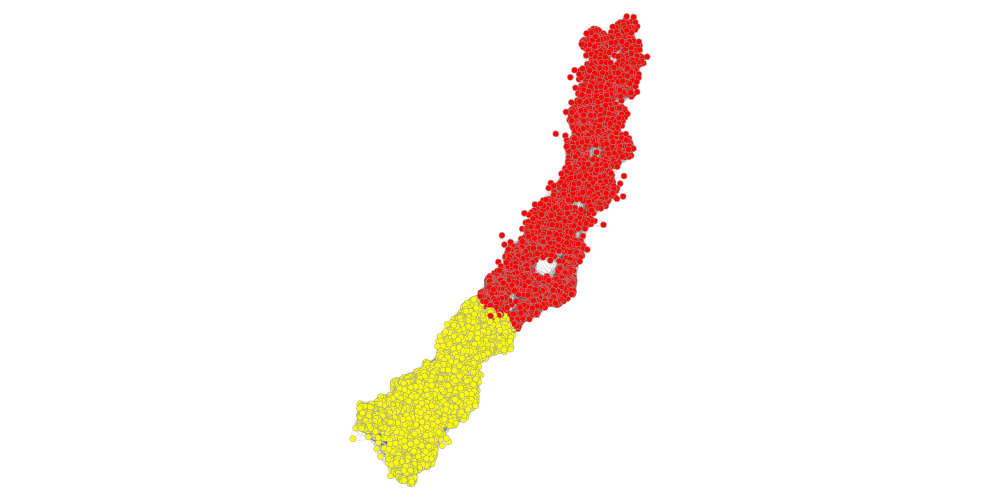

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13a3377f0, at 0x128549c18>

In [10]:
# Read graph. This also supports gml and graphml format.
g = graph_class_local.GraphLocal('./datasets/senate.graphml','graphml')

# Create an object for global spectral partitioning
sp = spectral_partitioning.Spectral_partitioning()

# Call the global spectral partitioning algorithm.
output_sp = sp.produce([g])

# Only one input graph is given, i.e., [g]. 
# Extract the array from position 0 and store it.
eig2 = output_sp[0]

# Create an object for the sweep cut rounding procedure.
sc = sweepCut_general.SweepCut_general()

# Round the eigenvector
output_sc = sc.produce([g],p=eig2)

# Extract the partition for g and store it.
eig2_rounded = output_sc[0][0]

# Add data to graphtool.
g_gtool = load_graph("./datasets/senate.graphml")
    
remove_self_loops(g_gtool)

# Compute a layout for the graph.
pos = sfdp_layout(g_gtool, gamma=10.0, mu=10.0, mu_p=10.0, verbose = False)  

# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 0.00001

eig2_rounded_c = diff(range(g._num_vertices), eig2_rounded)

temp[eig2_rounded] = 6
temp[eig2_rounded_c] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in eig2_rounded:
    temp[i] = "yellow"
for i in eig2_rounded_c:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1)

# Improve the initial partition using MQI

In [11]:
# Create an object for subgraph node partitioning.
mqi_fast = MQI_fast.MQI_fast()

# Conductance before improvement
print("Conductance before improvement:",g.compute_conductance(eig2_rounded))

# Start calling MQI
start = time.time()
output_MQI_fast = mqi_fast.produce([g],[eig2_rounded])
end = time.time()
print("running time:",str(end-start)+"s")

# Conductance after improvement
print("Conductance after improvement:",g.compute_conductance(output_MQI_fast[0][0]))

output_MQI = output_MQI_fast[0][0]

Conductance before improvement: 0.0128150852869
running time: 0.6977651119232178s
Conductance after improvement: 0.0101952652497


# Visualize the output of MQI

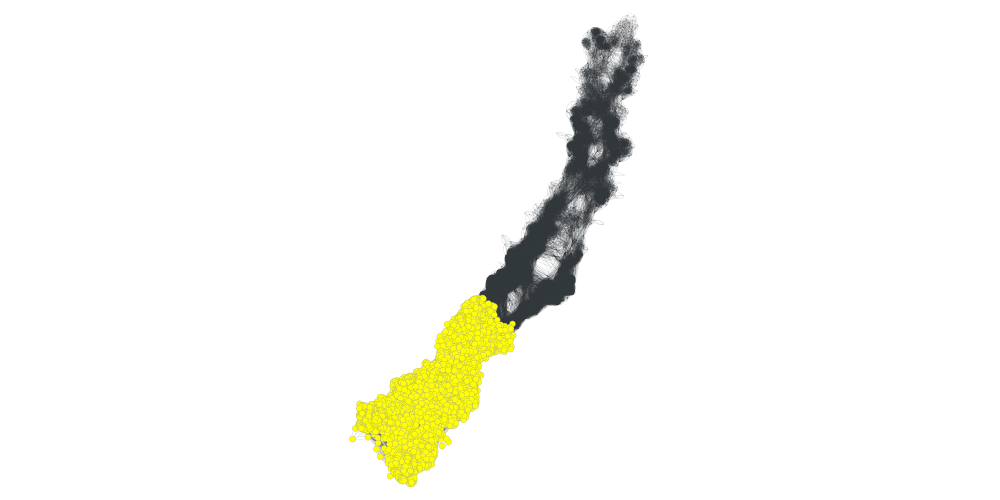

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13a3377f0, at 0x128549c18>

In [12]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 0.00001

temp[output_MQI] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_MQI:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1)

# Improve the initial partition using Simple Local

In [13]:
# Create an object for subgraph node partitioning.
SL_fast = SimpleLocal_fast.SimpleLocal_fast()

# Conductance before improvement
print("Conductance before improvement:",g.compute_conductance(eig2_rounded))

# Start calling SimpleLocal
start = time.time()
output_SL_fast = SL_fast.produce([g],[eig2_rounded])
end = time.time()
print("running time:",str(end-start)+"s")

# Conductance after improvement
print("Conductance after improvement:",g.compute_conductance(output_SL_fast[0][0]))

output_SL = output_SL_fast[0][0]

Conductance before improvement: 0.0128150852869
running time: 2.359407901763916s
Conductance after improvement: 0.00969042551351


# Visualize the output of Simple Local

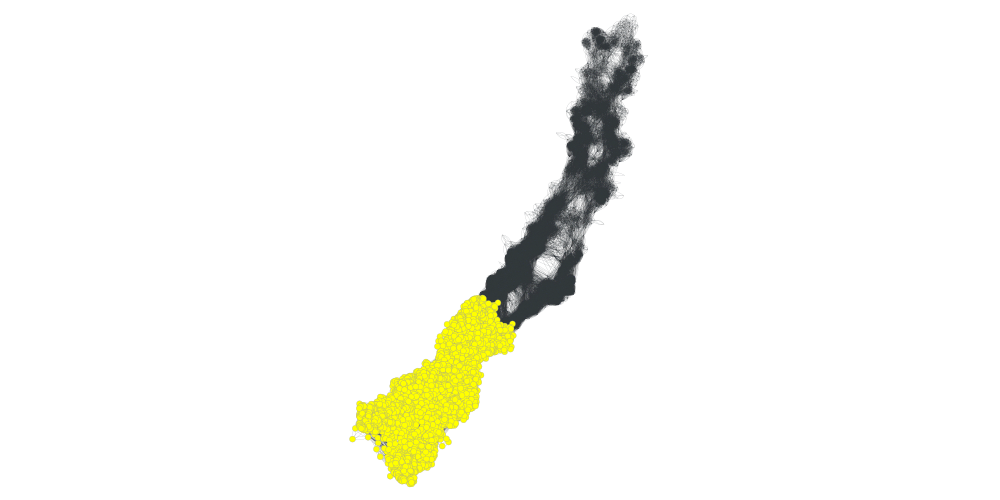

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13a3377f0, at 0x128549c18>

In [14]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 0.00001

temp[output_SL] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_SL:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1)